In [1]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import pandas as pd
from keras.utils import np_utils
from sklearn.cluster import KMeans
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10

In [3]:
def GetGSCFeatureData():
    gscSamePair = pd.read_csv('GSC-Dataset/GSC-Features-Data/same_pairs.csv') 
    gscDiffPair = pd.read_csv('GSC-Dataset/GSC-Features-Data/diffn_pairs.csv')
    #Reading human observed feature data csv 
    gscFeatureData = pd.read_csv('GSC-Dataset/GSC-Features-Data/GSC-Features.csv')
    #print(humanFeatureData.img_id)
    #print(humanSamePair.img_id_A, humanSamePair.img_id_B) 

    sameFeatureMerge=pd.merge(gscSamePair, gscFeatureData,  how='inner', left_on=['img_id_A'], right_on = ['img_id'], suffixes= ['_A','_A'])
    featureListSame=pd.merge(sameFeatureMerge, gscFeatureData, how='inner', left_on=['img_id_B'], right_on = ['img_id'], suffixes= ['_A','_B'])
    #print(featureListSame)

    diffFeatureMerge=pd.merge(gscDiffPair, gscFeatureData,  how='inner', left_on=['img_id_A'], right_on = ['img_id'], suffixes= ['_A','_A'])
    featureListDiff=pd.merge(diffFeatureMerge, gscFeatureData, how='inner', left_on=['img_id_B'], right_on = ['img_id'], suffixes= ['_A','_B'])
    return sameFeatureMerge, featureListSame, diffFeatureMerge, featureListDiff
    #print(featureListDiff.iloc[2])

In [4]:
sameFeatureMerge, featureListSame, diffFeatureMerge, featureListDiff = GetGSCFeatureData()
#Getting the array vector of Target values from 'same_pairs.csv'.
def ProcessData(featureListSame,featureListDiff):
    t1 = []
    t1_target=[]
    t2_target=[]
    columns =[2]
    columnnext=range(4,4+512)
    columnrest=range(5+512,5+512*2)
    columns.extend(columnnext)
    columns.extend(columnrest)
    #columns.extend(range(4,4+512)).extend(range(5+512,5+512*2))
    t1 = np.array(featureListSame.iloc[:,columns].values)
    t2 = np.array(featureListDiff.iloc[0:featureListSame.shape[0],columns].values)
    t1=np.concatenate((t2,t1))
    np.random.shuffle(t1)
    print(t1)
    return t1
t1 = ProcessData(featureListSame,featureListDiff)
print(t1.shape)

[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(143062, 1025)


# Getting data for the dataset

In [5]:
#Getting the matrix of total data
def GenerateRawData(t1):    
    dataMatrix = [] 
    
    dataMatrix = np.transpose(t1)     
    print ("Data Matrix Shape.."+ str(dataMatrix.shape))
    return dataMatrix

def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(rawData.shape[0]*0.01*TrainingPercent))
    print("RawData"+str(rawData.shape))
    d2 = rawData[0:T_len,:]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2


#Generating the list of validation target values which is 10% of total length
#List of size 10% of the total length will be obtained.
def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(rawData.shape[0]*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount:V_End-1]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t

GenerateRawData(t1)

def GenerateValData(rawData, ValPercent, TrainingCount): 
    #ceil() returns ceiling value of x i.e the smallest integer not less than x.
    valSize = int(math.ceil(rawData.shape[0]*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[TrainingCount:V_End-1,:]
    print("Validation Data Matrix"+str(dataMatrix.shape))  
    return dataMatrix

Data Matrix Shape..(1025, 143062)


# Fetch and Prepare Dataset

In [6]:
RawData = np.array(t1[:,1:])
RawTarget = np.array(t1[:,0:1])
print (RawData.shape)
print (RawTarget.shape)

(143062, 1024)
(143062, 1)


# Prepare Training Data

In [7]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
TrainingData= np.transpose(TrainingData)
print(TrainingTarget.shape)
print(TrainingData.shape)

RawData(143062, 1024)
(114450, 1)
(1024, 114450)


# Prepare Validation Data

In [8]:
#We have used np.array for ValDataAct because it is of list type and we want
# it to be of array type
#print(len(TrainingTarget))
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
ValData = np.transpose(ValData)
print(ValDataAct.shape)
print(ValData.shape)

Validation Data Matrix(14306, 1024)
(14306, 1)
(1024, 14306)


# Prepare Test Data

In [9]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
TestData = np.transpose(TestData)
print(ValDataAct.shape)
print(ValData.shape)

Validation Data Matrix(14306, 1024)
(14306, 1)
(1024, 14306)


# Sigmoid activation

In [10]:
def predict(features, weights):
    print("Feature shape :"+ str(features.shape))
    #print("Weights shape :"+ str(weights.shape))
    z = np.dot(features, weights)
    return sigmoid(z)

In [11]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Cost function

In [12]:
def cost_function(features, labels, weights):
    '''
    Using Mean Absolute Error

    Features:(100,3)
    Labels: (100,1)
    Weights:(3,1)
    Returns 1D matrix of predictions
    Cost = ( log(predictions) + (1-labels)*log(1-predictions) ) / len(labels)
    '''
    observations = len(labels)

    predictions = predict(features, weights)

    #Take the error when label=1
    class1_cost = -labels*np.log(predictions)

    #Take the error when label=0
    class2_cost = (1-labels)*np.log(1-predictions)

    #Take the sum of both costs
    cost = class1_cost - class2_cost

    #Take the average cost
    cost = cost.sum()/observations
    print("Cost: "+str(cost))

    return cost

In [13]:
def update_weights(features, labels, weights, lr):
    '''
    Vectorized Gradient Descent

    Features:(200, 3)
    Labels: (200, 1)
    Weights:(3, 1)
    '''
    N = len(features)

    #1 - Get Predictions
    predictions = predict(features, weights)

    #2 Transpose features from (200, 3) to (3, 200)
    # So we can multiply w the (200,1)  cost matrix.
    # Returns a (3,1) matrix holding 3 partial derivatives --
    # one for each feature -- representing the aggregate
    # slope of the cost function across all observations
    gradient = np.dot(features.T,  predictions - labels)

    #3 Take the average cost derivative for each feature
    gradient /= N

    #4 - Multiply the gradient by our learning rate
    gradient *= lr

    #5 - Subtract from our weights to minimize cost
    weights -= gradient

    return weights

In [14]:
def train(features, labels, weights, lr, iters):
    cost_history = []

    for i in range(iters):
        weights = update_weights(features, labels, weights, lr)

        #Calculate error for auditing purposes
        cost = cost_function(features, labels, weights)
        cost_history.append(cost)

        # Log Progress
        if i % 1000 == 0:
            print ("iter: "+str(i) + " cost: "+str(cost))

    return weights, cost_history

In [15]:
def accuracy_model(predicted_labels, actual_labels):
    count=0
    print("predicted_labels :"+ str(predicted_labels.shape))
    print("actual_labels :"+ str(actual_labels.shape))
    for i in range(len(predicted_labels)):
        if np.around(predicted_labels[i])==actual_labels[i]:
            count=count+1;
    accuracy= (count/len(predicted_labels))*100
    print("Accuracy: "+ str(accuracy))
    return accuracy

Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 0.6838318068749721
iter: 0 cost: 0.6838318068749721
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 0.7915225649813765
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 2.6869830002538664
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 3.9802344783370667
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 2.909074848176768
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 3.7203078944222976
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 3.1038404625675575
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 3.4791206985526353
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 3.2788073315491197
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 3.2537836266520817
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 3.4355682244361043
Feature shape :(143062, 1024)
Fea

Cost: 2.240672950463794
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 2.064833279585461
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 2.2233233381744126
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 2.051906726644226
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 2.206159752222499
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 2.0392495131818675
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 2.1891731769323015
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 2.026843714891734
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 2.17235640192674
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 2.0146727173705545
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 2.1557036769443716
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 2.002721137459435
Feature shape :(143062, 1024)
Feature shape :(14

Cost: 1.5922178294189373
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 1.5671095726853208
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 1.584222464426186
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 1.5568939784974802
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 1.5763023663350275
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 1.5468122062143717
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 1.5684588672777724
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 1.53686334511666
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 1.5606932163682055
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 1.52704642609006
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 1.55300656964802
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 1.5173604222579857
Feature shape :(143062, 1024)
Feature shape :(1

Cost: 1.2040241510804897
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 1.2922711904996524
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 1.1986062943222158
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 1.2878061138940602
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 1.1932508803482154
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 1.2833878264722822
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 1.1879566894148728
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 1.2790152515578033
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 1.182722532564163
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 1.2746873413051825
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 1.1775472514045655
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 1.2704030770843713
Feature shape :(143062, 1024)
Feature sha

Cost: 1.1172833543492644
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 0.9950620626389863
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 1.1142855830587328
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 0.9917240921565559
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 1.1113085136593779
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 0.988414872469848
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 1.1083519168357059
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 0.9851340436175968
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 1.1054155679354063
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 0.9818812521061115
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 1.1024992467418842
Feature shape :(143062, 1024)
Feature shape :(143062, 1024)
Cost: 0.9786561507212463
Feature shape :(143062, 1024)
Feature sha

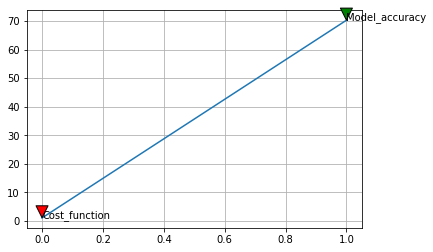

In [20]:
#Training model for different hyperparameters RawData, RawTarget, Weights, learning rate, epochs
weights,cost=train(RawData,RawTarget,np.zeros((RawData.shape[1],1)),0.2,400)
Cost_function=cost_function(RawData,RawTarget,weights)
predictedVal=predict(RawData,weights)
print("predictedVal :"+str(predictedVal.shape))
Model_accuracy=accuracy_model(predict(RawData,weights),RawTarget)
print("Cost_function :"+str(Cost_function))

#In order to plot the graph
plt.plot([Cost_function,Model_accuracy])
plt.annotate('Cost_function', (0,Cost_function), (0,Cost_function),
            arrowprops=dict(facecolor='red', shrink=0.05),
            )
plt.annotate('Model_accuracy', (1,Model_accuracy), (1,Model_accuracy),
            arrowprops=dict(facecolor='green', shrink=0.05),
            )
plt.grid()
plt.show()